# Survey Validation Data Challenge - Summer 2018

### Notebook 2 -- Tile the BGS/GAMA Fields and run survey simulations

The purpose of this notebook is to construct a set of DESI tiles (pointings) for each of the GAMA/BGS fields and to simulate observations of just the G02 field.

In [1]:
import os, sys, time, subprocess
import glob
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
import fitsio
from astropy.table import Table

In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, palette='Set2')

In [4]:
%matplotlib inline

In [5]:
print("Starting at {}".format(time.asctime()))
notebook_start_time = time.time()

Starting at Tue Jun 26 09:04:01 2018


## Define various directories and input/output filenames.

Define and create directories under `$DESI_ROOT/datachallenge/svdc-summer2018` and set environment variables for this mapping:

| Directory             | NB variable   | Environment Variable                              |
|-----------------------|---------------|---------------------------------------------------|
| survey/               | surveydir     | \$DESISURVEY_OUTPUT                               |
| targets/              | targetdir     |                                                   |
| fiberassign/          | fibassigndir  |                                                   |
| spectro/redux/mini/   | reduxdir      | \$DESI_SPECTRO_REDUX/\$SPECPROD                   |
| spectro/sim/mini/     | simdatadir    | \$DESI_SPECTRO_DATA = \$DESI_SPECTRO_SIM/$PIXPROD |

In [6]:
basedir = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'svdc-summer2018')
codedir = os.path.join(os.getenv('DESI_PRODUCT_ROOT'), 'survey-validation', 'svdc-summer2018')

In [7]:
surveydir = os.path.join(basedir, 'survey')
targetdir = os.path.join(basedir, 'targets')
fibassigndir = os.path.join(basedir, 'fiberassign')

os.environ['DESISURVEY_OUTPUT'] = surveydir
os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
os.environ['DESI_SPECTRO_SIM'] = os.path.join(basedir, 'spectro', 'sim')
os.environ['PIXPROD'] = 'bgs-gama'
os.environ['SPECPROD'] = 'bgs-gama'

reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
os.environ['DESI_SPECTRO_DATA'] = simdatadir

for dd in (surveydir, targetdir, fibassigndir, reduxdir, simdatadir):
    os.makedirs(dd, exist_ok=True)

In [8]:
samplefile = os.path.join(basedir, 'bgs-gama-sample.fits')
tilesfile = os.path.join(basedir, 'bgs-gama-tiles.fits')
G02tilesfile = os.path.join(basedir, 'bgs-gama-tiles-G02.fits')
surveyconfigfile = os.path.join(codedir, 'survey-config.yaml')

#### Specify the random seed for reproducibility of the survey simulations.

In [9]:
seed = 123

In [10]:
nside_mock_targets = 64

#### Specify whether the output catalog should be overwritten.

If *overwrite_tiles=True* all the output files and plots will be recreated.

In [11]:
overwrite_tiles = False
overwrite_surveysim = False
overwrite_mock_spectra = False
overwrite_fiberassign = False
overwrite_simspec = True

## Read the parent sample of GAMA targets.
This parent sample was written by the *bgs-gama-sample.ipynb* notebook.

In [12]:
def read_gama_sample():
    if os.path.isfile(samplefile):
        gama = Table(fitsio.read(samplefile, ext=1))
        print('Read {} objects from {}'.format(len(gama), samplefile))
    else:
        print('Sample file {} not found!'.format(samplefile))
        gama = []
    return gama

In [13]:
gama = read_gama_sample()
gama

Read 123646 objects from /Users/ioannis/work/desi/datachallenge/svdc-summer2018/bgs-gama-sample.fits


CATAID,GAMA_NAME,IC_FLAG,N_SPEC,N_GAMA_SPEC,DIST,SPECID,SURVEY,SURVEY_CODE,RA_GAMA,DEC_GAMA,WMIN,WMAX,Z,NQ,PROB,FILENAME,URL,URL_IMG,D4000N,HB_EW,HA_EW,FIELD,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],EBV,FLUX_U,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,FLUX_Y,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_U,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_I,FLUX_IVAR_Z,FLUX_IVAR_Y,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_U,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_I,MW_TRANSMISSION_Z,MW_TRANSMISSION_Y,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_U,NOBS_G,NOBS_R,NOBS_I,NOBS_Z,NOBS_Y,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_U,RCHISQ_G,RCHISQ_R,RCHISQ_I,RCHISQ_Z,RCHISQ_Y,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_U,FRACFLUX_G,FRACFLUX_R,FRACFLUX_I,FRACFLUX_Z,FRACFLUX_Y,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_U,FRACMASKED_G,FRACMASKED_R,FRACMASKED_I,FRACMASKED_Z,FRACMASKED_Y,FRACIN_U,FRACIN_G,FRACIN_R,FRACIN_I,FRACIN_Z,FRACIN_Y,ANYMASK_U,ANYMASK_G,ANYMASK_R,ANYMASK_I,ANYMASK_Z,ANYMASK_Y,ALLMASK_U,ALLMASK_G,ALLMASK_R,ALLMASK_I,ALLMASK_Z,ALLMASK_Y,WISEMASK_W1,WISEMASK_W2,PSFSIZE_U,PSFSIZE_G,PSFSIZE_R,PSFSIZE_I,PSFSIZE_Z,PSFSIZE_Y,PSFDEPTH_U,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_I,PSFDEPTH_Z,PSFDEPTH_Y,GALDEPTH_U,GALDEPTH_G,GALDEPTH_R,GALDEPTH_I,GALDEPTH_Z,GALDEPTH_Y,WISE_COADD_ID,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,MAGGIES [3],IVARMAGGIES [3],BESTMAGGIES [3],MASS,COEFFS [5],CHI2,CFLUX_4861,CFLUX_6563,UGRIZ_ABSMAG_01 [5],UGRIZ_ABSMAG_01_IVAR [5],UGRIZ_KCORRECT_01 [5]
int32,bytes23,int16,int16,int16,float32,bytes33,bytes9,int16,float64,float64,float32,float64,float32,int16,float32,bytes67,bytes88,bytes92,float32,float32,float32,bytes9,int32,int32,bytes8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
6802,GAMAJ113601.43+004315.3,4104,1,1,0.07,G12_Y3_017_187,GAMA,5,174.006,0.72093,3727.71,8857.67,0.05054,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y3_017_187.png,1.8113052,5.2033396,27.802761,G12,5000,335384,1741p007,1933,EXP,174.00598622398962,0.7209393932303215,6988468600000.0,4191433300000.0,419401.47 .. 536835.56,0.022343148,0.0,21.893206,36.97496,0.0,53.05904,0.0,34.971066,24.96587,34.99477,13.33904,0.0,312.8943,194.10887,0.0,48.34676,0.0,1.4591584,0.2886607,0.0008888335,2.0130388e-05,0.9210764,0.9359996,0.95642483,0.9677694,0.97538704,0.9783421,0.99622065,0.9976773,0.99950415,0.9998127,0,7,7,0,6,0,71,71,14,14,0.0,1.2658782,1.3420198,0.0,1.4313744,0.0,1.3802189,0.9311673,0.5148549,0.22353429,0.0,1.7470633e-09,-2.6956257e-09,0.0,-1.6094196e-09,0.0,0.0046206336,0.02367005,0.42563543,19.007805,0.0,0.005900223,0.0064123627,0.0,0.0035908138,0.0

## Tile the G02, G09, G12, and G15 GAMA fields.

As an initial effort, we tile each of the GAMA fields very simplistically, using constant offsets in RA and Dec.  The next iteration of this notebook will need to consider the dither pattern required to fill in the gaps in the DESI focal plane due to the central bullseye (0.2 deg) and the GFA gaps (0.4 deg).

In [14]:
def simple_radec_off_scheme(ras, decs, dx=0.6, ang=42):
    """Code written by E. Schlafly (LBNL).
    
    Take a single covering and define four sets of offsets, starting with something 
    minimal. 
    
    Need to cover central bulls-eyes (0.2 deg) and GFA gaps (p to 0.4 deg).

    """
    ang = np.radians(ang)
    dang = np.pi/2
    dithers = [[0, 0], 
               [dx*np.sin(ang+0*dang), dx*np.cos(ang+0*dang)], 
               [dx*np.sin(ang+1*dang), dx*np.cos(ang+1*dang)],
               [dx*np.sin(ang+2*dang), dx*np.cos(ang+2*dang)]]
    dithers = np.cumsum(np.array(dithers), axis=0)
    dithers = list(dithers) + [[np.mean([d[0] for d in dithers]),
                                np.mean([d[1] for d in dithers])]]
    fac = 1./np.cos(np.radians(decs))
    fac = np.clip(fac, 1, 360*5)  # confusion near celestial pole.
    newras = np.concatenate([ras+d[0]*fac for d in dithers])
    newdecs = np.concatenate([decs+d[1] for d in dithers])
    newdecs = np.clip(newdecs, -np.inf, 90.)
    newras = newras % 360
    newras = np.concatenate([newras, newras])
    newdecs = np.concatenate([newdecs, newdecs])
    
    return newras, newdecs

In [15]:
def radec2tiles(ra, dec, tileid_start=100000):
    """Given an input set of tile coordinates (centers), return a 
    table of tiles.
    
    """
    from astropy.table import Table, Column
    
    ntile = len(np.atleast_1d(ra))
    
    tiles = Table()
    tiles.add_column(Column(name='TILEID', dtype='i4', length=ntile))
    tiles.add_column(Column(name='RA', dtype='f8', length=ntile))
    tiles.add_column(Column(name='DEC', dtype='f8', length=ntile))
    tiles.add_column(Column(name='PASS', dtype=np.int16, length=ntile))
    tiles.add_column(Column(name='IN_DESI', dtype=np.int16, length=ntile))
    tiles.add_column(Column(name='EBV_MED', dtype='f4', length=ntile))
    tiles.add_column(Column(name='AIRMASS', dtype='f4', length=ntile))
    tiles.add_column(Column(name='STAR_DENSITY', dtype='f4', length=ntile))
    tiles.add_column(Column(name='EXPOSEFAC', dtype='f4', length=ntile))
    tiles.add_column(Column(name='PROGRAM', dtype='S6', length=ntile))
    tiles.add_column(Column(name='OBSCONDITIONS', dtype='i4', length=ntile))
    
    tiles['RA'] = ra
    tiles['DEC'] = dec
    tiles['TILEID'] = (np.arange(ntile) + tileid_start).astype('i4')
    tiles['PASS'] = 1          # ??
    tiles['AIRMASS'] = 1.0     # to be filled in by surveysim
    tiles['IN_DESI'] = 1       # assume all "in DESI"
    tiles['EXPOSEFAC'] = 1.0   # ??
    tiles['PROGRAM'] = 'DARK'
    tiles['OBSCONDITIONS'] = 1 # ??
    
    return tiles

In [16]:
def plot_tile(ra, dec, r=1.606, color='k', ax=None):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(x,y, '-', color=color, alpha=0.5)

In [17]:
def read_gama_tiles(gamafield=None):
    if gamafield:
        _tilesfile = tilesfile.replace('.fits', '-{}.fits'.format(gamafield))
    else:
        _tilesfile = tilesfile
    
    if os.path.isfile(_tilesfile):
        tiles = Table(fitsio.read(_tilesfile, ext=1))
        print('Read {} tiles from {}'.format(len(tiles), _tilesfile))
    else:
        print('Tiles file {} not found!'.format(_tilesfile))
        tiles = []
    return tiles

In [18]:
def qa_gama_tiles(gama=None, tiles=None, gamafield=None, overwrite=False):
    
    if gama is None:
        gama = read_gama_sample()
    if tiles is None:
        tiles = read_gama_tiles(gamafield=gamafield)

    fig, ax = plt.subplots(2, 2, figsize=(10, 6))
    ax = ax.reshape(4)
    
    for thisax, field in zip(ax, sorted(set(gama['FIELD']))):
        
        infield = gama['FIELD'] == field
    
        if np.count_nonzero(infield) > 0:
            thisax.scatter(gama['RA'][infield], gama['DEC'][infield], 
                           s=1, alpha=0.5, marker='s')
        
            ww = ( (tiles['RA'] > gama['RA'][infield].min()) * (tiles['RA'] < gama['RA'][infield].max()) * 
                   (tiles['DEC'] > gama['DEC'][infield].min()) * (tiles['DEC'] < gama['DEC'][infield].max()) )
            for tt in tiles[ww]:
                plot_tile(tt['RA'], tt['DEC'], ax=thisax)
            
        thisax.set_xlabel('RA')
        thisax.set_ylabel('Dec')
        thisax.invert_xaxis()
        thisax.set_title(field)
    
    fig.tight_layout()
    if overwrite:
        pngfile = os.path.join(basedir, 'qaplots', 'qa-gama-tiles.png')
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)    

In [19]:
def gama_tiles(gama, radius=1.6, gamafield=None, debug=False, overwrite=False):
    """Tile each of the GAMA fields."""
    
    gama_radec = { # Field corners
        'G02': (30.2, 38.8, -6, -4),
        'G09': (129, 141, -2, 3),
        'G12': (174, 186, -3, 2),
        'G15': (211.5, 223.5, -2, 3),
        'G23': (339, 351, -35, -30)
    }    

    if gamafield:
        keep = [ff.decode('utf-8') == gamafield for ff in gama['FIELD'].data]
        gama = gama[keep]
        print(gama['RA'].min(), gama['RA'].max(), gama['DEC'].min(), gama['DEC'].max())
    
        _tilesfile = tilesfile.replace('.fits', '-{}.fits'.format(gamafield))
    else:
        _tilesfile = tilesfile
        
    if not overwrite and os.path.isfile(_tilesfile):
        tiles = Table.read(_tilesfile)
        print('Read {} tiles from existing file {}'.format(len(tiles), _tilesfile))
    
    ra_allfields, dec_allfields = [], []
    for field in sorted(set(gama['FIELD'])):
        infield = gama['FIELD'] == field

        # Get the tile centers very simplistically.
        nra = np.ceil( (gama_radec[field][1] - gama_radec[field][0]) / radius ).astype('int') + 1
        ndec = np.ceil( (gama_radec[field][3] - gama_radec[field][2]) / radius ).astype('int') - 1

        allra = np.linspace(gama_radec[field][0] - radius/2, gama_radec[field][1] + radius/2, nra)
        if ndec == 1:
            alldec = np.repeat( np.mean( [gama_radec[field][2], gama_radec[field][3]] ), ndec)
        else:
            alldec = np.linspace(gama_radec[field][2] + radius/2, gama_radec[field][3] - radius/2, ndec)

        ra, dec = [], []
        for dd in alldec:
            ra.append(allra)
            dec.append(np.repeat(dd, nra))

        ra = np.array(ra).flatten()
        dec = np.array(dec).flatten()

        # Simpler dither scheme
        #ra2, dec2 = simple_radec_off_scheme(ra, dec, dx=1.4, ang=330)
        #ra2, dec2 = simple_radec_off_scheme(ra, dec, dx=0.6, ang=42)

        ra_allfields.append(ra)
        dec_allfields.append(dec)
        
        if debug:
            fig, ax = plt.subplots()
            ax.scatter(gama['RA'][infield], gama['DEC'][infield], s=1, alpha=0.5)
            ax.invert_xaxis()
            ax.title(field)
            for rr, dd in zip(ra, dec):
                plot_tile(rr, dd, ax=ax)
            plt.show()

    ra = np.hstack(ra_allfields).flatten()
    dec = np.hstack(dec_allfields).flatten()
            
    tiles = radec2tiles(ra, dec)
    if gamafield == 'G02':
        print('Temporary hack -- writing just the first two tiles!')
        tiles = tiles[:2]
    
    if overwrite:
        print('Writing {}'.format(_tilesfile))
        tiles.write(_tilesfile, overwrite=overwrite)
    
    return tiles

In [20]:
tiles = gama_tiles(gama, debug=False, overwrite=overwrite_tiles)
tiles

Read 88 tiles from existing file /Users/ioannis/work/desi/datachallenge/svdc-summer2018/bgs-gama-tiles.fits


TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,bytes6,int32
100000,29.4,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1
100001,31.099999999999998,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1
100002,32.8,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1
100003,34.5,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1
100004,36.199999999999996,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1
100005,37.89999999999999,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1
100006,39.599999999999994,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1
100007,128.2,-1.2,1,1,0.0,1.0,0.0,1.0,DARK,1
100008,129.89999999999998,-1.2,1,1,0.0,1.0,0.0,1.0,DARK,1


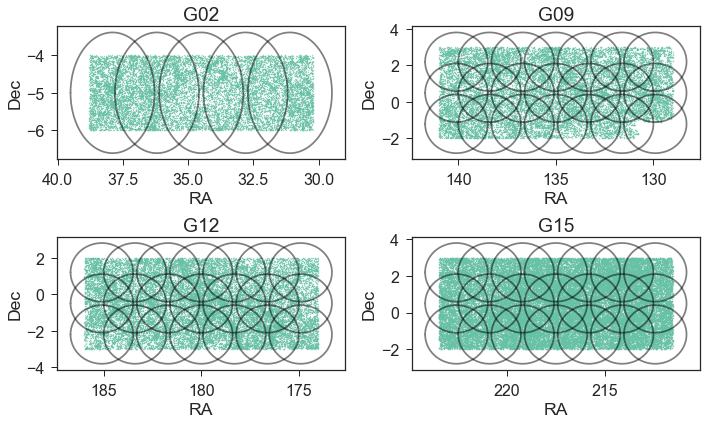

In [21]:
qa_gama_tiles(gama, tiles, overwrite=overwrite_tiles)

#### Read/write a tile file of just the G02 field.

In [22]:
G02tiles = gama_tiles(gama, gamafield='G02', debug=False, overwrite=overwrite_tiles)
G02tiles

30.20076527943862 38.799158265159285 -5.999944208185486 -4.000168852918386
Read 2 tiles from existing file /Users/ioannis/work/desi/datachallenge/svdc-summer2018/bgs-gama-tiles-G02.fits
Temporary hack -- writing just the first two tiles!


TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,bytes6,int32
100000,29.4,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1
100001,31.099999999999998,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1


## Run survey simulations

Simulate SV observing of just the G02 field.

One outstanding question is whether we need a new set of rules when calling *surveyplan* other than those in [desisurvey/data](https://github.com/desihub/desisurvey/tree/master/py/desisurvey/data).

In [23]:
def survey_simulations(tiles, overwrite=False):
    """Run survey simulations."""
    expfile = os.path.join(surveydir, 'exposures.fits')
    progressfile = os.path.join(surveydir, 'progress.fits')
    
    if overwrite or not os.path.isfile(expfile):
        from desisurvey.progress import Progress
        from desisurvey.config import Configuration
        from surveysim.util import add_calibration_exposures
    
        Configuration.reset()
        config = Configuration(surveyconfigfile)

        survey_logname = os.path.join(surveydir, 'survey.log')
        print('Running survey simulations; logging to {}'.format(survey_logname)) ; print()
        
        with open(survey_logname, 'w') as logfile:
            cmd = "surveyinit --recalc --config-file {} --output-path {}".format(surveyconfigfile, surveydir)
            print(cmd) ; print()
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            # Use 0d fiber assignment delay to move on with mini sim quickly
            # Do we need new rules?!?
            cmd = "surveyplan --config-file {} --output-path {} --create --fa-delay 0d".format(
                surveyconfigfile, surveydir)
            print(cmd) ; print()
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            cmd = "surveysim --config-file {} --output-path {} --seed {}".format(
                surveyconfigfile, surveydir, seed)
            print(cmd) ; print()
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            # Do we need new rules?!?
            plan_cmd = 'surveyplan --config-file {} --output-path {} --fa-delay 0d'.format(
                surveyconfigfile, surveydir)
            sim_cmd = 'surveysim --resume --config-file {} --output-path {} --seed {}'.format(
                surveyconfigfile, surveydir, seed)
            print(sim_cmd) ; print()
            while True:
                lastdate = open(os.path.join(surveydir, 'last_date.txt')).readline().strip()
                progress = Table.read(os.path.join(surveydir, 'progress.fits'), 1)
                ndone = np.count_nonzero(progress['status'] == 2)
                print('Starting {} with {}/{} tiles completed {}'.format(
                    lastdate, ndone, len(progress), time.asctime()))
                if subprocess.call(plan_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                    break
                if subprocess.call(sim_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                    break

        # Make sure observing truly finished.
        if not os.path.exists(progressfile):
            print("ERROR: Missing {}".format(progressfile))
            print("Check {} for what might have gone wrong".format(survey_logname))
    
        print('Files in {}:\n'.format(surveydir))
        !ls $surveydir
        
        # convert progress.fits -> exposures.fits
        p = Progress(restore=os.path.join(surveydir, 'progress.fits'))
        explist = p.get_exposures()
        explist = add_calibration_exposures(explist)

        # Sanity check that all tiles in the subset were observed in the exposures list.
        if not np.all(np.in1d(tiles['TILEID'], explist['TILEID'])):
            print("ERROR: some tiles weren't observed;\ncheck {} for failures".format(survey_logname) )
            print("Missing TILEIDs:", set(tiles['TILEID']) - set(explist['TILEID']))
        else:
            print('All tiles in the subset were observed at least once.')
            explist.write(expfile, overwrite=True)
            print('Writing {}'.format(expfile))                

        # Optionally make a movie
        if False:
            cmd = "surveymovie --config-file {} --output-path {}".format(
                surveyconfigfile, surveydir)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0
    else:
        print('Simulated observing already completed.')
        explist = Table.read(expfile)
        print('Read {} exposures from {}'.format(len(explist), expfile))

    return explist

In [24]:
%time explist = survey_simulations(G02tiles, overwrite=overwrite_surveysim)
explist

Simulated observing already completed.
Read 11 exposures from /Users/ioannis/work/desi/datachallenge/svdc-summer2018/survey/exposures.fits
CPU times: user 233 ms, sys: 59.1 ms, total: 292 ms
Wall time: 298 ms


EXPID,TILEID,PASS,RA,DEC,EBMV,NIGHT,MJD,EXPTIME,SEEING,TRANSPARENCY,AIRMASS,MOONFRAC,MOONALT,MOONSEP,PROGRAM,FLAVOR
,,,deg,deg,,,,s,arcsec,,,,deg,deg,,
int32,int32,int16,float64,float64,float32,bytes8,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes7
0,-1,-1,0.0,0.0,0.0,20190904,58731.29590,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALIB,arc
1,-1,-1,0.0,0.0,0.0,20190904,58731.29637,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALIB,arc
2,-1,-1,0.0,0.0,0.0,20190904,58731.29683,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALIB,arc
3,-1,-1,0.0,0.0,0.0,20190904,58731.29729,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALIB,flat
4,-1,-1,0.0,0.0,0.0,20190904,58731.29775,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALIB,flat
5,-1,-1,0.0,0.0,0.0,20190904,58731.29822,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALIB,flat
6,100000,1,29.4,-5.0,0.0,20190904,58731.29868,775.5,1.3,0.9,2.0,0.414,-17.1,142.2,DARK,science
7,100000,1,29.4,-5.0,0.0,20190904,58731.30904,956.7,1.3,0.9,2.0,0.414,-17.1,142.2,DARK,science


#### Visualize which healpixels cover the observed tiles.

In [25]:
def plot_healpix(nside, pixels, ax=None):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    if ax is None:
        fig, ax = plt.subplots()
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        ax.plot(ra, dec, '-', color='0.6') 

In [26]:
def tiles2pixels(tiles, nside=64):
    import desimodel.footprint
    pixels = desimodel.footprint.tiles2pix(nside, tiles)
    nexp = np.count_nonzero(np.in1d(explist['TILEID'], tiles['TILEID']))
    print('{} tiles covered by {} exposures and {} nside={} healpixels'.format(
        len(tiles), nexp, len(pixels), nside))
    return pixels

In [27]:
def qa_observed_tiles():
    isbright = explist['PROGRAM'] == 'BRIGHT'
    isgray = explist['PROGRAM'] == 'GRAY'
    isdark = explist['PROGRAM'] == 'DARK'
    
    fig, ax = plt.subplots()
    ax.plot(tiles['RA'], tiles['DEC'], 'k.', alpha=0.2, label='_none_')
    ax.plot(explist['RA'][isdark], explist['DEC'][isdark], 'o', color='k', ms=10, mew=2, label='dark')
    if np.sum(isgray) > 0:
        ax.plot(explist['RA'][isgray], explist['DEC'][isgray], 's', 
                color='0.6', ms=10, label='gray')
    if np.sum(isbright) > 0:
        ax.plot(explist['RA'][isbright], explist['DEC'][isbright], 'd', 
                color='m', ms=10, mew=2, label='bright')
    ax.legend(loc='upper right')
    #ax.set_xlim(148, 157)
    #ax.set_ylim(28, 37)

In [28]:
def qa_tiles2pixels(tiles, nside=64, overwrite=False):
    
    pixels = tiles2pixels(tiles, nside=nside)
    sci = explist['FLAVOR'] == 'science'
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    ax1.scatter(explist['RA'][sci], explist['DEC'][sci], marker='o', 
                alpha=0.7, label='Exposures')
    ax1.scatter(tiles['RA'], tiles['DEC'], marker='s', edgecolor='k', 
                facecolor='none', lw=2, label='Tile Centers')
    ax1.legend(loc='upper left', markerscale=1.5)
    ax1.invert_xaxis()
    ax1.set_xlabel('RA')
    ax1.set_ylabel('Dec')

    plot_healpix(nside, pixels, ax=ax2)
    color = dict(DARK='k', GRAY='b', BRIGHT='m')
    for program in ['DARK', 'GRAY', 'BRIGHT']:
        ii = (tiles['PROGRAM'] == program)
        ax2.plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
        jj = tiles['PROGRAM'] == program
        for t in tiles[jj]:
            plot_tile(t['RA'], t['DEC'], color=color[program], ax=ax2)
            
    xlim = ax2.get_xlim()
    ax2.set_xlim(xlim)
    ax1.set_xlim(xlim)
    #xlim(143, 161); ylim(28, 37)
    
    fig.tight_layout()
    if overwrite:
        pngfile = os.path.join(basedir, 'qaplots', 'qa-gama-tiles-healpixels.png')
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)        
    
    return pixels

2 tiles covered by 5 exposures and 29 nside=64 healpixels


array([17526, 17527, 17532, 17533, 17534, 17535, 17621, 17674, 17675,
       17678, 17696, 17697, 17698, 17699, 17700, 17701, 17702, 17703,
       17704, 17705, 17706, 17707, 17708, 17709, 17710, 17711, 17792,
       17793, 17796])

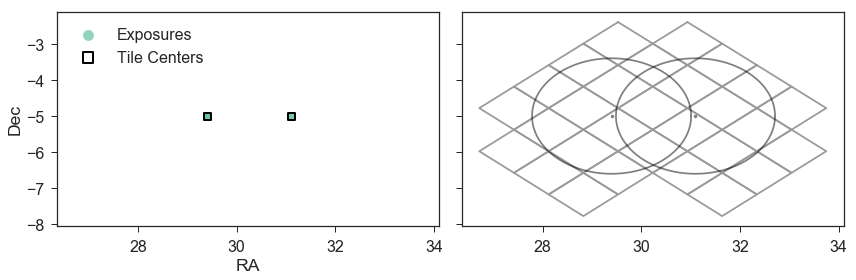

In [29]:
pixels = qa_tiles2pixels(G02tiles, nside=nside_mock_targets, overwrite=overwrite_tiles)
pixels

## Simulate noiseless spectra using select_mock_targets.

Then, merge the target, sky, and stdstar catalogs and build the Merged Target List (MTL) file.

In [30]:
def is_select_mock_targets_done(tilesfile, nside=64, verbose=False):
    """Check whether select_mock_targets successfully finished."""
    tiles = Table(fitsio.read(tilesfile, ext=1))
    pixels = tiles2pixels(tiles, nside=nside)
    
    done = True
    for filetype in ['target', 'truth', 'sky', 'standards-dark', 'standards-bright']:
        filenames = glob.glob(os.path.join(targetdir, '*', '*', '{}*.fits'.format(filetype)))
        if verbose:
            print('{}/{} {} files'.format(len(filenames), len(pixels), filetype))
        if len(filenames) != len(pixels):
            done = False
    return done

In [31]:
def select_mock_targets(tilesfile, nside=64, overwrite=False, verbose=False):
    """Run select_mock_targets."""
    
    logfilename = os.path.join(targetdir, 'select_mock_targets.log')
    if overwrite or not is_select_mock_targets_done(tilesfile, nside=nside, verbose=verbose):
            
        print('Starting select_mock_targets at {}'.format(time.asctime()))
        print('Logging to {}'.format(logfilename))

        configfile = os.path.join(codedir, 'mock-targets.yaml')
    
        #cmd = "srun -A desi -N 15 -n 30 -c 16 -C haswell -t 00:30:00 --qos interactive"
        #cmd += " mpi_select_mock_targets --output_dir {targetdir} --config {configfile}"
        #cmd += " --seed 1 --nproc 16 --nside 64 --tiles {tilefile}"
    
        cmd = "select_mock_targets --output_dir {targetdir} --config {configfile}"
        cmd += " --seed {seed} --nproc 4 --nside {nside} --tiles {tilesfile} --overwrite"
        cmd = cmd.format(targetdir=targetdir, tilesfile=tilesfile, configfile=configfile, 
                         seed=seed, nside=nside)
        print(cmd)
    
        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
            if err != 0:
                print('select_mock_targets failed err={}; see {}'.format(err, logfilename))
            else:
                print('done at {}'.format(time.asctime()))
                
    else:
        print('All done with select_mock_targets; see log file {}'.format(logfilename))            

In [32]:
def join_targets_truth_mtl(overwrite=False):
    mtlfile = os.path.join(targetdir, 'mtl.fits')
    truthfile = os.path.join(targetdir, 'truth.fits')
    targetsfile = os.path.join(targetdir, 'targets.fits')

    if (overwrite or not os.path.isfile(mtlfile) or not os.path.isfile(targetsfile) or
        not os.path.isfile(truthfile)):
        
        cmd = "join_mock_targets --mockdir {} --force".format(targetdir)
        print(cmd)
        err = subprocess.call(cmd.split())
        if err != 0:
            print('join_mock_targets failed err={}'.format(err))
        else:
            print('Successfully joined all targets and truth catalogs.')
    else:
        print('Using existing truth.fits {}'.format(truthfile))        
        print('Using existing targets.fits file {}'.format(targetsfile))        
        print('Using existing merged target list {}'.format(mtlfile))        

In [33]:
%time select_mock_targets(G02tilesfile, nside=nside_mock_targets, verbose=True, overwrite=overwrite_mock_spectra)

2 tiles covered by 5 exposures and 29 nside=64 healpixels
29/29 target files
29/29 truth files
29/29 sky files
29/29 standards-dark files
29/29 standards-bright files
All done with select_mock_targets; see log file /Users/ioannis/work/desi/datachallenge/svdc-summer2018/targets/select_mock_targets.log
CPU times: user 17.7 ms, sys: 9.9 ms, total: 27.6 ms
Wall time: 25.2 ms


In [34]:
%time join_targets_truth_mtl(overwrite=overwrite_mock_spectra)

Using existing truth.fits /Users/ioannis/work/desi/datachallenge/svdc-summer2018/targets/truth.fits
Using existing targets.fits file /Users/ioannis/work/desi/datachallenge/svdc-summer2018/targets/targets.fits
Using existing merged target list /Users/ioannis/work/desi/datachallenge/svdc-summer2018/targets/mtl.fits
CPU times: user 1.18 ms, sys: 703 µs, total: 1.88 ms
Wall time: 1.56 ms


#### [ToDo] Targeting QA.

## Fiber assignment

In [35]:
def is_fiberassign_done(tilesfile, verbose=False):
    """Check whether fiberassign successfully finished."""
    
    tiles = Table(fitsio.read(tilesfile, ext=1))
    done = True
    for tileid in tiles['TILEID']:
        tilefile = os.path.join(fibassigndir, 'tile_{:05d}.fits'.format(tileid))
        if not os.path.exists(tilefile):
            done = False
            if verbose:
                print('Missing {}'.format(tilefile))

    return done

In [36]:
def run_fiberassign(tilesfile, overwrite=False, verbose=False):
    
    if overwrite or not is_fiberassign_done(tilesfile, verbose=verbose):

        print('Generating lists of dark and bright tiles')
        tiles = Table(fitsio.read(tilesfile, ext=1))

        bx, dx = None, None
        for tileid, program  in zip(tiles['TILEID'], tiles['PROGRAM']):
            if program == 'BRIGHT':
                if bx is None:
                    bx = open(os.path.join(fibassigndir, 'bright-tiles.txt'), 'w')
                bx.write(str(tileid)+'\n')
            else:
                if dx is None:
                    dx = open(os.path.join(fibassigndir, 'dark-tiles.txt'), 'w')
                dx.write(str(tileid)+'\n')
        if bx:
            bx.close()
        if dx:
            dx.close()

        # Remove any leftover tile files
        for tilefile in glob.glob(fibassigndir+'/tile_*.fits'):
            os.remove(tilefile)

        cmd = "fiberassign "
        cmd += " --mtl {}/mtl.fits".format(targetdir)
        cmd += " --stdstar {}/{{stdfile}}".format(targetdir)
        cmd += " --sky {}/sky.fits".format(targetdir)
        cmd += " --surveytiles {}/{{surveytiles}}".format(fibassigndir)
        cmd += " --footprint {tilesfile}"
        #cmd += " --positioners {}/data/focalplane/fiberpos.fits".format(os.getenv('DESIMODEL'))
        cmd += " --fibstatusfile {}/fiberstatus.ecsv".format(codedir)
        cmd += " --outdir {}".format(fibassigndir)

        # Run fiberassign
        logfilename = os.path.join(fibassigndir, 'fiberassign.log')
        print('Logging to {}'.format(logfilename)) ; print()
        with open(logfilename, 'w') as logfile:
            for program in ['dark', 'bright']:
                stdfile = 'standards-{}.fits'.format(program)
                surveytiles = '{}-tiles.txt'.format(program)
                if os.path.isfile(os.path.join(fibassigndir, surveytiles)):
                    cmdx = cmd.format(stdfile=stdfile, surveytiles=surveytiles,
                                      tilesfile=tilesfile)
                    print(cmdx)
                
                    err = subprocess.call(cmdx.split(), stdout=logfile, stderr=logfile)
                    if err != 0:
                        print('fiberassign failed err={}; see {}'.format(err, logfilename))
        
        if is_fiberassign_done(tilesfile, verbose=True):
            print('Success; running QA.')
            print()
            !qa-fiberassign $fibassigndir/tile*.fits --targets $targetdir/targets.fits
            #cmd = 'qa-fiberassign {}/tile*.fits'.format(fibassigndir)
            #cmd += ' --targets {}/targets.fits'.format(targetdir)
            #print(cmd)
            #err = subprocess.call(cmd.split(), stdout=subprocess.PIPE)#, stderr=logfile)#, stderr=sys.stderr)
        else:
            print('ERROR: missing fiberassign output files')
        
    else:
        print('Finished fiber assignment; see log file {}'.format(logfile))            

In [37]:
%time run_fiberassign(G02tilesfile, overwrite=overwrite_fiberassign)

UnboundLocalError: local variable 'logfile' referenced before assignment

### Combine surveysim, mocks, and fiberassign into simspec files.

Here, we associates exposure IDs (EXPID) to observations and insert 3 arcs and 3 flats at the beginning of each night.

[This took roughly 20 minutes on my laptop with two tiles.]

In [38]:
def is_newexp_done(explist, verbose=False):    
    numnights = len(set(explist['NIGHT']))
    nexp = len(explist)  #- 3 arc/night + 3 flat/night + science
    simspecfiles = glob.glob(simdatadir+'/*/simspec*.fits')
    fibermapfiles = glob.glob(simdatadir+'/*/fibermap*.fits')
    if verbose:
        print('{}/{} simspec files'.format(len(simspecfiles), nexp))
        print('{}/{} fibermap files'.format(len(fibermapfiles), nexp))

    if len(simspecfiles) != nexp:
        return False
    elif len(fibermapfiles) != nexp:
        return False
    else:
        return True

In [43]:
def run_newexp(tilefile, explist, overwrite=False):
    """Run newexp."""
    
    logfilename = os.path.join(simdatadir, 'newexp.log')
    if overwrite or not is_newexp_done(explist):
        logfilename = os.path.join(simdatadir, 'newexp.log')
        print('Logging to {}'.format(logfilename))

        cmd = " wrap-newexp --fiberassign {}".format(fibassigndir)
        cmd += " --mockdir {}".format(targetdir)
        cmd += " --obslist {}/exposures.fits".format(surveydir)
        cmd += " --tilefile {}".format(tilefile)
        #cmd += " --dryrun"
        if overwrite:
            cmd += " --force"
        
        print('Starting at {}'.format(time.asctime()))
        if 'NERSC_HOST' in os.environ:
            nodes = 15
            nersc_cmd = "srun -A desi -N {nodes} -n {nodes} -c 32".format(nodes=nodes)
            nersc_cmd += " -C haswell -t 00:15:00 --qos interactive"
            cmd = nersc_cmd+cmd
        print(cmd)

        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            if err != 0:
                print('ERROR {} running wrap-newexp; see {}'.format(err, logfilename))
            else:
                print('done')            
    else:
        print('newexp is done')
        is_newexp_done(explist, verbose=True)

In [ ]:
%time run_newexp(G02tilesfile, explist, overwrite=overwrite_simspec)

Logging to /Users/ioannis/work/desi/datachallenge/svdc-summer2018/spectro/sim/bgs-gama/newexp.log
Starting at Tue Jun 26 09:08:47 2018
 wrap-newexp --fiberassign /Users/ioannis/work/desi/datachallenge/svdc-summer2018/fiberassign --mockdir /Users/ioannis/work/desi/datachallenge/svdc-summer2018/targets --obslist /Users/ioannis/work/desi/datachallenge/svdc-summer2018/survey/exposures.fits --tilefile /Users/ioannis/work/desi/datachallenge/svdc-summer2018/bgs-gama-tiles-G02.fits --force


### Generate noisy uncalibrated spectra  using fastframe.

In [41]:
def is_fastframe_done(explist, reduxdir, verbose=False):
    nflat = np.count_nonzero(explist['FLAVOR'] == 'flat')
    nscience = np.count_nonzero(explist['FLAVOR'] == 'science')
    nframe = 30*(nflat + nscience)
    framefiles = glob.glob(reduxdir+'/exposures/*/*/frame*.fits')
    if verbose:
        print('{}/{} frame files'.format(len(framefiles), nframe))
    
    if len(framefiles) != nframe:
        return False
    else:
        return True

In [42]:
def run_fastframe(overwrite=False):
    if is_fastframe_done(explist, reduxdir, verbose=True):
        print('fastframe already done; skipping')
    else:
        logfilename = os.path.join(reduxdir, 'exposures', 'fastframe.log')
        os.makedirs(os.path.dirname(logfilename), exist_ok=True)
        print('Running fastframe batch job; should take ~7 min')
        print('Starting at {}'.format(time.asctime()))
        print('Logging to {}'.format(logfilename))
        
        nodes = 15

        cmd = "srun -A desi -N {nodes} -n {nodes} -c 32 -C haswell -t 00:20:00 --qos interactive".format(nodes=nodes)
        cmd += " wrap-fastframe --mpi"
        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            if err != 0:
                print('ERROR {} running wrap-fastframe; see {}'.format(err, logfilename))
            else:
                print('done at {}'.format(time.asctime()))

        if is_fastframe_done(explist, reduxdir, verbose=True):
            print('SUCCESS')
        else:
            print('ERROR; see {}'.format(logfilename))